In [1]:
import os  # Mengimpor modul os untuk bekerja dengan sistem file dan direktori
import librosa  # Mengimpor pustaka librosa untuk analisis dan pemrosesan audio
import numpy as np  # Mengimpor pustaka numpy untuk operasi numerik
from fastdtw import fastdtw  # Mengimpor fungsi fastdtw untuk menghitung Dynamic Time Warping dengan cepat
from scipy.spatial.distance import euclidean  # Mengimpor fungsi euclidean untuk menghitung jarak Euclidean
import pickle  # Mengimpor pustaka pickle untuk menyimpan dan memuat objek Python
import soundfile as sf  # Mengimpor pustaka soundfile untuk membaca file audio
import matplotlib.pyplot as plt  # Mengimpor pustaka matplotlib untuk visualisasi

def extract_features(file_path):
    y, sr = sf.read(file_path)  # Menggunakan soundfile untuk membaca file .opus dan mengembalikan sinyal audio (y) dan sampling rate (sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Mengekstrak Mel-Frequency Cepstral Coefficients (MFCCs) dari sinyal audio
    return mfccs, y, sr  # Mengembalikan MFCCs, sinyal audio, dan sampling rate

def calculate_dtw_distance(feature1, feature2):
    distance, path = fastdtw(feature1.T, feature2.T, dist=euclidean)  # Menghitung jarak DTW dan jalur optimal antara dua set fitur menggunakan jarak Euclidean
    return distance, path  # Mengembalikan jarak DTW dan jalur optimal

def save_model(model, file_path):
    with open(file_path, 'wb') as f:  # Membuka file untuk menulis dalam mode biner
        pickle.dump(model, f)  # Menyimpan model ke file menggunakan pickle

def load_model(file_path):
    with open(file_path, 'rb') as f:  # Membuka file untuk membaca dalam mode biner
        model = pickle.load(f)  # Memuat model dari file menggunakan pickle
    return model  # Mengembalikan model yang dimuat


In [2]:
data_latih_folder = 'data_latih/tajweed'  # Mendefinisikan path folder data latih

# Ekstraksi fitur untuk setiap jenis tajweed
tajweeds = [d for d in os.listdir(data_latih_folder) if os.path.isdir(os.path.join(data_latih_folder, d))]  # Mendapatkan daftar folder yang ada di dalam folder data_latih

for tajweed in tajweeds:  # Looping melalui setiap jenis tajweed
    tajweed_folder = os.path.join(data_latih_folder, tajweed)  # Mendefinisikan path folder untuk jenis tajweed tertentu
    files = [os.path.join(tajweed_folder, f) for f in os.listdir(tajweed_folder) if f.endswith('.opus')]  # Mendapatkan daftar file .opus dalam folder tajweed
    
    if not files:  # Jika folder kosong, lanjutkan ke iterasi berikutnya
        print(f"Skipping empty folder: {tajweed_folder}")
        continue
    
    tajweed_features = [extract_features(file)[0] for file in files]  # Mengekstrak fitur dari setiap file audio tajweed
    
    # Simpan model untuk setiap jenis tajweed
    save_model(tajweed_features, f'{tajweed}_model.pkl')  # Menyimpan fitur tajweed sebagai model

print("All models saved successfully.")  # Menampilkan pesan bahwa semua model telah disimpan


All models saved successfully.


In [3]:
test_audio_path = 'test.opus'  # Mendefinisikan path file audio uji
test_features, test_signal, sr = extract_features(test_audio_path)  # Mengekstrak fitur dari file audio uji

print("Test features extracted successfully.")  # Menampilkan pesan bahwa fitur data uji telah diekstraksi


Test features extracted successfully.


In [4]:
segment_length = 2 * sr  # Mendefinisikan panjang segmen dalam sampel (2 detik)
num_segments = len(test_signal) // segment_length  # Menghitung jumlah segmen 2 detik dalam sinyal audio uji

segment_results = []  # Inisialisasi daftar untuk menyimpan hasil deteksi segmen

for i in range(num_segments):  # Looping melalui setiap segmen
    start = i * segment_length  # Mendefinisikan indeks awal segmen
    end = start + segment_length  # Mendefinisikan indeks akhir segmen
    segment = test_signal[start:end]  # Mengambil segmen sinyal audio uji
    segment_mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)  # Mengekstrak MFCCs dari segmen
    
    best_similarity = 0  # Inisialisasi nilai kemiripan terbaik
    best_tajweed = None  # Inisialisasi tajweed terbaik
    
    for tajweed in tajweeds:  # Looping melalui setiap jenis tajweed
        model_path = f'{tajweed}_model.pkl'
        if not os.path.exists(model_path):  # Memeriksa apakah model ada
            print(f"Model for {tajweed} not found, skipping.")
            continue
        
        tajweed_features = load_model(model_path)  # Memuat model tajweed
        if not tajweed_features:  # Jika tidak ada fitur dalam model, skip
            continue
        
        distances = [calculate_dtw_distance(train_feature, segment_mfcc)[0] for train_feature in tajweed_features]  # Menghitung jarak DTW untuk setiap fitur tajweed dengan segmen
        min_distance = min(distances)  # Mendapatkan jarak minimum
        similarity = 100 - ((min_distance - min(distances)) / (max(distances) - min(distances)) * 100)  # Menghitung kemiripan dalam persen
        
        if similarity > best_similarity:  # Memeriksa apakah kemiripan saat ini adalah yang terbaik
            best_similarity = similarity  # Memperbarui kemiripan terbaik
            best_tajweed = tajweed  # Memperbarui tajweed terbaik
    
    if best_similarity >= 20:  # Jika kemiripan terbaik di atas atau sama dengan 20%, simpan hasil
        segment_results.append((i, best_tajweed, best_similarity))  # Menyimpan hasil deteksi untuk segmen saat ini
    else:
        print(f"Segment {i} has low similarity ({best_similarity}%), skipping.")
        
print("Pattern detection completed.")  # Menampilkan pesan bahwa deteksi pola telah selesai


Pattern detection completed.


C:\Users\User\AppData\Local\Temp\ipykernel_1060\2304863736.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(tajweeds))  # Mendapatkan colormap untuk membedakan warna tajweed


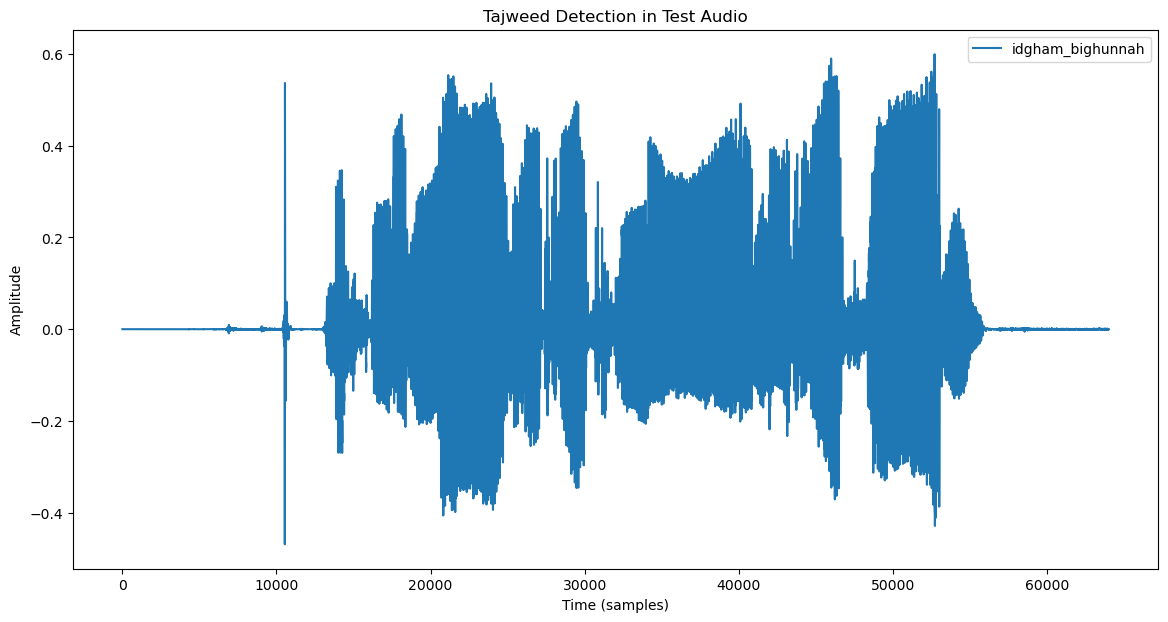

In [5]:
colors = plt.cm.get_cmap('tab20', len(tajweeds))  # Mendapatkan colormap untuk membedakan warna tajweed

plt.figure(figsize=(14, 7))  # Membuat figur dengan ukuran 14x7 inci
time_stamps = [i * 2 for i, _, _ in segment_results]  # Membuat daftar time stamps untuk setiap segmen

for i, (segment, tajweed, _) in enumerate(segment_results):  # Looping melalui setiap hasil deteksi segmen
    start = i * segment_length  # Mendefinisikan indeks awal segmen
    end = start + segment_length  # Mendefinisikan indeks akhir segmen
    plt.plot(range(start, end), test_signal[start:end], color=colors(tajweeds.index(tajweed)), label=tajweed if i == 0 else "")  # Plot sinyal dengan warna berbeda untuk setiap tajweed

plt.xlabel('Time (samples)')  # Memberikan label pada sumbu x
plt.ylabel('Amplitude')  # Memberikan label pada sumbu y
plt.title('Tajweed Detection in Test Audio')  # Memberikan judul pada grafik
plt.legend(loc='upper right')  # Menampilkan legenda di pojok kanan atas
plt.show()  # Menampilkan grafik


C:\Users\User\AppData\Local\Temp\ipykernel_1060\2134517290.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(tajweeds))  # Mendapatkan colormap untuk membedakan warna tajweed


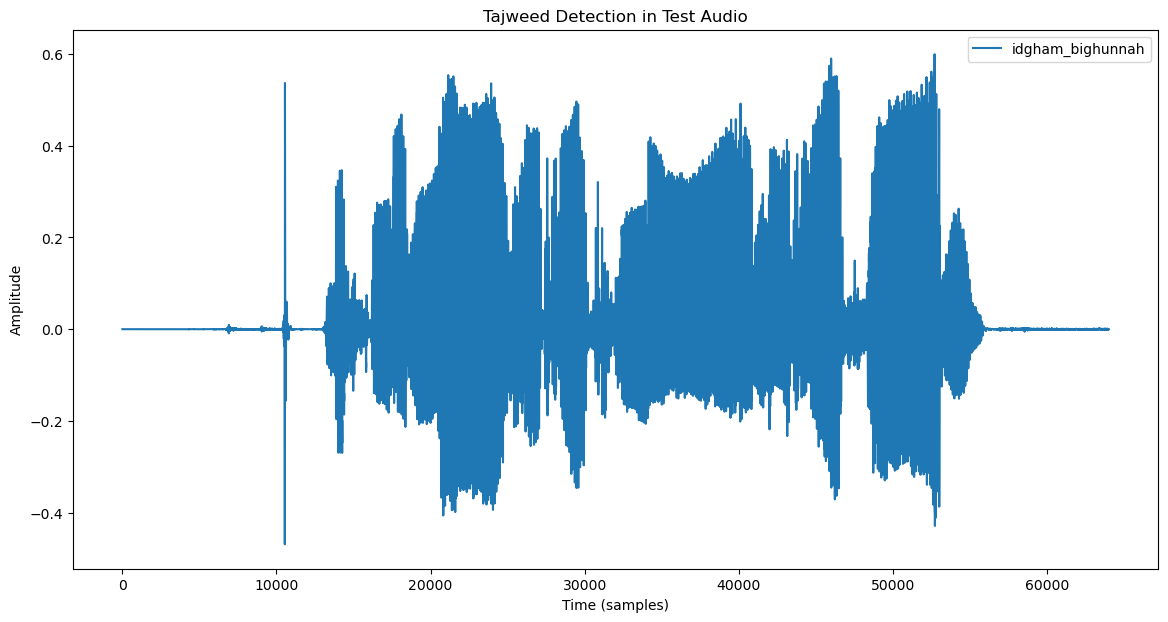

In [6]:
# Import library yang dibutuhkan
import matplotlib.pyplot as plt

# Fungsi untuk visualisasi pola suara
def plot_detected_tajweed_segments(test_signal, segment_results, sr, segment_length, tajweeds):
    """
    Visualisasikan hasil deteksi tajweed pada segmen-segmen sinyal audio uji.
    
    Parameters:
    - test_signal: Sinyal audio uji
    - segment_results: Hasil deteksi segmen berupa daftar tuple (index segmen, jenis tajweed, kemiripan)
    - sr: Sampling rate audio
    - segment_length: Panjang segmen dalam sampel
    - tajweeds: Daftar nama tajweed
    """
    colors = plt.cm.get_cmap('tab20', len(tajweeds))  # Mendapatkan colormap untuk membedakan warna tajweed
    
    plt.figure(figsize=(14, 7))  # Membuat figur dengan ukuran 14x7 inci
    
    for i, (segment_index, tajweed, _) in enumerate(segment_results):  # Looping melalui setiap hasil deteksi segmen
        start = segment_index * segment_length  # Mendefinisikan indeks awal segmen
        end = start + segment_length  # Mendefinisikan indeks akhir segmen
        plt.plot(range(start, end), test_signal[start:end], color=colors(tajweeds.index(tajweed)), label=tajweed if i == 0 else "")  # Plot sinyal dengan warna berbeda untuk setiap tajweed

    plt.xlabel('Time (samples)')  # Memberikan label pada sumbu x
    plt.ylabel('Amplitude')  # Memberikan label pada sumbu y
    plt.title('Tajweed Detection in Test Audio')  # Memberikan judul pada grafik
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')  # Menampilkan legenda di pojok kanan atas
    plt.show()  # Menampilkan grafik

# Variabel ini perlu sudah terdefinisi dari bagian sebelumnya
# test_signal, sr, segment_length, segment_results, tajweeds

# Panggil fungsi untuk visualisasi hasil deteksi tajweed
plot_detected_tajweed_segments(test_signal, segment_results, sr, segment_length, tajweeds)


In [7]:
# Import library yang dibutuhkan
import matplotlib.pyplot as plt

# Fungsi untuk visualisasi pola suara dan hasil deteksi tajweed
def plot_combined_signals(test_signal, segment_results, sr, segment_length, tajweeds, title):
    """
    Visualisasikan hasil deteksi tajweed pada segmen-segmen sinyal audio uji dengan sinyal audio asli.
    
    Parameters:
    - test_signal: Sinyal audio uji
    - segment_results: Hasil deteksi segmen berupa daftar tuple (index segmen, jenis tajweed, kemiripan)
    - sr: Sampling rate audio
    - segment_length: Panjang segmen dalam sampel
    - tajweeds: Daftar nama tajweed
    - title: Judul visualisasi
    """
    colors = plt.cm.get_cmap('tab20', len(tajweeds))  # Mendapatkan colormap untuk membedakan warna tajweed
    
    plt.figure(figsize=(14, 7))  # Membuat figur dengan ukuran 14x7 inci
    
    plt.plot(test_signal, label='Test Signal', alpha=0.7, color='grey')  # Plot sinyal uji dengan warna abu-abu
    
    for i, (segment_index, tajweed, _) in enumerate(segment_results):  # Looping melalui setiap hasil deteksi segmen
        start = segment_index * segment_length  # Mendefinisikan indeks awal segmen
        end = start + segment_length  # Mendefinisikan indeks akhir segmen
        plt.plot(range(start, end), test_signal[start:end], color=colors(tajweeds.index(tajweed)), label=tajweed if i == 0 else "")  # Plot sinyal dengan warna berbeda untuk setiap tajweed

    plt.xlabel('Time (samples)')  # Memberikan label pada sumbu x
    plt.ylabel('Amplitude')  # Memberikan label pada sumbu y
    plt.title(title)  # Memberikan judul pada grafik
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')  # Menampilkan legenda di pojok kanan atas
    plt.tight_layout()  # Menyesuaikan padding di sekitar subplot
    plt.show()  # Menampilkan grafik

# Ambil sinyal dan path untuk audio latih paling mirip
most_similar_train_features = loaded_train_features[most_similar_index]  # Mendapatkan fitur audio latih paling mirip

# Visualisasikan sinyal uji dengan hasil deteksi tajweed
plot_combined_signals(test_signal, segment_results, sr, segment_length, tajweeds, 'Most Similar Audio and Tajweed Detection')


NameError: name 'loaded_train_features' is not defined